<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/collaborative_filtering_%EC%97%B0%EC%8A%B5(4)_%EC%95%84%EC%9D%B4%ED%85%9C_%EA%B8%B0%EB%B0%98_%ED%98%91%EC%97%85_%ED%95%84%ED%84%B0%EB%A7%81(item_based_collaborative_filtering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아이템 기반 협업 필터링  

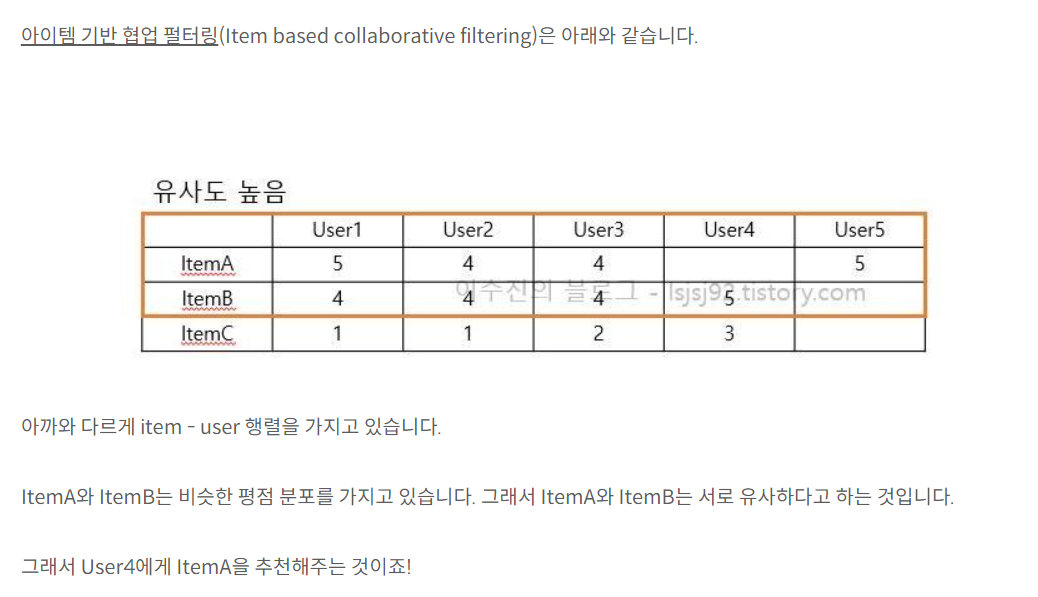

In [116]:
# !pip install datasets
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datasets import load_dataset

## 데이터로드 및 전처리

도서관데이터

In [111]:
# 필요한 컬럼 # 시설명, 구이름, 장소구분
lib = pd.read_csv('seoul_libs.csv', encoding='utf-8')
lib.head()

# 밸류값이 모두 'lib'인 ['type'] 칼럼 추가
lib['type'] = 'lib'

# 컬럼명 변경
cols= {'도서관 일련번호':'place_id', '도서관명':'place_name', '구명':'gu_name'}
lib = lib.rename(columns=cols)
lib.columns

# # 필요한 컬럼만 추출
lib=lib[['place_name', 'gu_name', 'type']]
lib.head()


,place_name,gu_name,type
0,BIBLIOTECA,강남구,lib
1,LH강남3단지작은도서관,강남구,lib
2,休+밤토리SH작은도서관,강남구,lib
3,강남구립못골도서관,강남구,lib
4,강남데시앙파크작은도서관,강남구,lib


공원데이터

In [112]:
# 필요한 컬럼 # 시설명, 구이름, 장소구분
par = pd.read_csv('seoul_parks.csv', encoding='utf-8')
par.head()
par.columns
# 밸류값이 모두 'par'인 ['type'] 칼럼 추가
par['type'] = 'par'

# 컬럼명 변경
cols= {'공원명':'place_name', '공원주소':'gu_name'}
par = par.rename(columns=cols)
par.columns

# 공원주소 컬럼에서 구 이름만 추출
par['gu_name'] = par['gu_name'].str.split(' ', expand=True)[1]

# 결측치 삭제
par = par.dropna()

# gu_name이 '구'로 끝나지 않으면 삭제
par = par[par['gu_name'].str.endswith('구')]

# # 필요한 컬럼만 추출
par=par[['place_name', 'gu_name', 'type']]
par.head()

,place_name,gu_name,type
0,남산도시자연공원,중구,par
12,여의도근린공원,영등포구,par
16,보라매근린공원,동작구,par
17,어린이대공원,광진구,par
18,천호근린공원,강동구,par


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('place_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('gu_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['gu_name'].value_counts()
    for x_label, grp in _df_2.groupby('place_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('place_name')
_ = plt.ylabel('gu_name')

박물관, 미술관 데이터

In [127]:
dataset = load_dataset("hscrown/seoul_museums")
muse = pd.DataFrame(dataset['train'])

muse.columns

# 밸류값이 모두 'muse'인 ['type'] 칼럼 추가
muse['type'] = 'muse'

# 컬럼명 변경
cols= {'시설명':'place_name', '주소':'gu_name'}
muse = muse.rename(columns=cols)

# 주소 컬럼에서 구 이름만 추출
muse['gu_name'] = muse['gu_name'].str.split(' ', expand=True)[1]

# gu_name이 '구'로 끝나지 않으면 삭제
muse = muse[muse['gu_name'].str.endswith('구')]
# # 필요한 컬럼만 추출
muse=muse[['place_name', 'gu_name', 'type']]

muse.tail()

Repo card metadata block was not found. Setting CardData to empty.


,place_name,gu_name,type
170,매헌윤봉길의사기념관,서초구,muse
171,동덕여자대학교 박물관,성북구,muse
172,DDP디자인뮤지엄,중구,muse
173,아모레퍼시픽미술관,용산구,muse
174,롯데뮤지엄,송파구,muse


In [139]:
# 공원데이터와 도서관 데이터 합침
df = pd.concat([lib, par,muse])
df.tail()

# 인덱스 초기화
df = df.reset_index(drop=True)

# 'place_id' 컬럼 만들고 인덱스 밸류로 넣기
df['place_id'] = df.index

df.head()

# df 를 csv 파일로 변환
df.to_csv('places.csv', index=False, encoding='utf-8')

In [133]:
df.tail()

,place_name,gu_name,type,place_id
1658,매헌윤봉길의사기념관,서초구,muse,1658
1659,동덕여자대학교 박물관,성북구,muse,1659
1660,DDP디자인뮤지엄,중구,muse,1660
1661,아모레퍼시픽미술관,용산구,muse,1661
1662,롯데뮤지엄,송파구,muse,1662


# 사용자 평점데이터 만들기

In [150]:
# df 이용해서 사용자 평점데이터 만들기
# place_id,user_id,rating

# user 수 만큼 df 복사하기

user1 = df.copy()

user1.shape # (1663, 4)

user1.columns # ['place_name', 'gu_name', 'type', 'place_id']

# place_name 칼럼 삭제
user1.drop(columns='place_name', inplace=True)

# gu_name은 user_id로, type는 rating으로 컬럼명 변경
user1.columns = ['user_id', 'rating','place_id']
user1['user_id'] = 0

user2 = user1.copy()
user3 = user2.copy()

user2['user_id'] = 1
user3['user_id'] = 2

# user1, user2, user3 데이터 합치기

user_rating = pd.concat([user1, user2, user3])

user_rating

user_rating.columns # ['place_name', 'gu_name', 'type', 'place_id']
# rating 컬럼에 nan 값에 0 넣기
user_rating['rating'] = user_rating['rating'].fillna(0)

# rating 컬럼에 0~5 사이의 실수 랜덤값 넣기. 1의 자리에서 반올림
# numpy 사용
user_rating['rating'] = np.round(np.random.uniform(0, 5, size=len(user_rating)), 1)

user_rating.head()


,user_id,rating,place_id
0,0,1.6,0
1,0,3.4,1
2,0,3.1,2
3,0,3.5,3
4,0,3.2,4


아이템-특성 데이터 만들기

In [161]:
# place_id, type, place_name만 추출
item_feature = df[['place_id', 'type', 'place_name','gu_name']]
item_feature.head()

,place_id,type,place_name,gu_name
0,0,lib,BIBLIOTECA,강남구
1,1,lib,LH강남3단지작은도서관,강남구
2,2,lib,休+밤토리SH작은도서관,강남구
3,3,lib,강남구립못골도서관,강남구
4,4,lib,강남데시앙파크작은도서관,강남구


# user_rating 데이터와 item_feature 데이터 머지 및 행렬화

In [163]:
# user_rating 데이터와 item_feature 데이터 머지
user_item_rating = pd.merge(user_rating, item_feature, on='place_id')

user_item_rating.head()

,user_id,rating,place_id,type,place_name,gu_name
0,0,1.6,0,lib,BIBLIOTECA,강남구
1,1,2.2,0,lib,BIBLIOTECA,강남구
2,2,0.4,0,lib,BIBLIOTECA,강남구
3,0,3.4,1,lib,LH강남3단지작은도서관,강남구
4,1,3.3,1,lib,LH강남3단지작은도서관,강남구


In [164]:
user_item_rating = user_item_rating.pivot_table('rating',index='place_name', columns='user_id')
user_item_rating.head()

user_id,0,1,2
place_name,,,
성신여자대학교자연사박물관,4.4,0.9,2.5
(사)국민문화연구소 자료실,1.5,3.9,1.2
(재)한원미술관,1.4,3.8,4.2
4.19혁명기념도서관,5.0,2.0,4.0
5세대sf작은도서관,2.9,1.3,0.3


In [168]:
from sklearn.metrics.pairwise import cosine_similarity
item_based_collab = cosine_similarity(user_item_rating)

In [169]:
item_based_collab = pd.DataFrame(data = item_based_collab, index=user_item_rating.index, columns=user_item_rating.index)
item_based_collab.head()

place_name,성신여자대학교자연사박물관,(사)국민문화연구소 자료실,(재)한원미술관,4.19혁명기념도서관,5세대sf작은도서관,63아트미술관,7단지 작은도서관,BIBLIOTECA,Book Bridge 작은 도서관,Book積북적도서관,...,휘경어린이도서관,휘경행복도서관,휴먼빌작은도서관,휴앤해피 작은도서관,흑석동작은도서관,흥부네작은도서관,희망문고,희망샘작은도서관,힐스테이트별빛작은도서관,힐즈도서관
place_name,,,,,,,,,,,,,,,,,,,,,
성신여자대학교자연사박물관,1.000000,0.586686,0.669580,0.980266,0.894690,0.941163,0.802836,0.708991,0.983969,0.695919,...,0.569093,0.951151,0.823778,0.946094,0.810467,0.807996,0.935024,0.918974,0.547574,0.925162
(사)국민문화연구소 자료실,0.586686,1.000000,0.865778,0.689222,0.704727,0.825687,0.878510,0.958722,0.718199,0.826169,...,0.880850,0.798985,0.941668,0.754074,0.738468,0.941663,0.803519,0.817156,0.494782,0.678935
(재)한원미술관,0.669580,0.865778,1.000000,0.802285,0.550891,0.822158,0.978176,0.765496,0.742559,0.996521,...,0.990722,0.848424,0.867541,0.873826,0.956053,0.931968,0.884801,0.904841,0.862970,0.873826
4.19혁명기념도서관,0.980266,0.689222,0.802285,1.000000,0.854590,0.968590,0.902232,0.759033,0.983660,0.824141,...,0.718058,0.985723,0.882868,0.991304,0.907826,0.889648,0.983553,0.976110,0.679105,0.977778
5세대sf작은도서관,0.894690,0.704727,0.550891,0.854590,1.000000,0.921511,0.706095,0.868174,0.934118,0.543653,...,0.477381,0.885149,0.875053,0.819261,0.608269,0.805766,0.843240,0.823240,0.223993,0.733173


In [170]:
def get_collab_sim(place_name):
    return item_based_collab[place_name].sort_values(ascending=False)

In [172]:
get_collab_sim('LH강남3단지작은도서관')[0:10]

place_name
LH강남3단지작은도서관       1.000000
K-Culture 작은도서관    0.999983
은평어린이영어도서관         0.999902
잠실3동새마을문고          0.999901
서울특별시대학교 미술관       0.999845
공덕동문고(마실길북카페)      0.999764
금호2.3가어린이작은도서관     0.999763
H HOUSE 라이브러리      0.999702
방배도서관              0.999694
안디아모작은도서관          0.999667
Name: LH강남3단지작은도서관, dtype: float64